In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
from typing import List
from scipy.stats import binom
%matplotlib inline
plt.style.use('seaborn')


In [16]:
!ls data

BTCUSD_multi_trades_v3.npy  Coinbase_LTCUSD_1h.csv	NORM
Coinbase_BTCUSD_1h.csv	    ETHUSD_multi_trades_v3.npy	TRADES
Coinbase_ETHUSD_1h.csv	    LTCUSD_multi_trades_v3.npy


In [17]:
DATA = Path('./data')
TRADES_PATH = DATA / 'TRADES'
TRADES_PATH.mkdir(exist_ok=True)

In [18]:
frame = pd.read_csv(DATA / 'Coinbase_BTCUSD_1h.csv')

In [19]:
len(frame)

9512

In [20]:
frame.describe()

,Open,High,Low,Close,Volume From,Volume To
count,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9.512000e+03
mean,7711.774907,7767.386755,7650.193580,7712.320312,675.621764,5.770474e+06
std,3589.234440,3629.649328,3542.255126,3588.834329,733.659892,8.428667e+06
min,1785.010000,1858.270000,1758.200000,1785.010000,0.000000,0.000000e+00
25%,4749.595000,4767.850000,4732.042500,4749.910000,264.425000,1.453309e+06
50%,7436.045000,7473.315000,7401.855000,7436.745000,459.660000,2.993231e+06
75%,9290.000000,9330.000000,9234.380000,9290.000000,816.017500,6.718756e+06
max,19847.110000,19891.990000,19725.980000,19847.110000,10464.320000,1.438437e+08


In [21]:
prices = frame['Close'].values

[Text(0,0.5,'Closing price'),
 Text(0.5,0,'Hours'),
 Text(0.5,1,'Closing price BTC/USD vs Hours')]

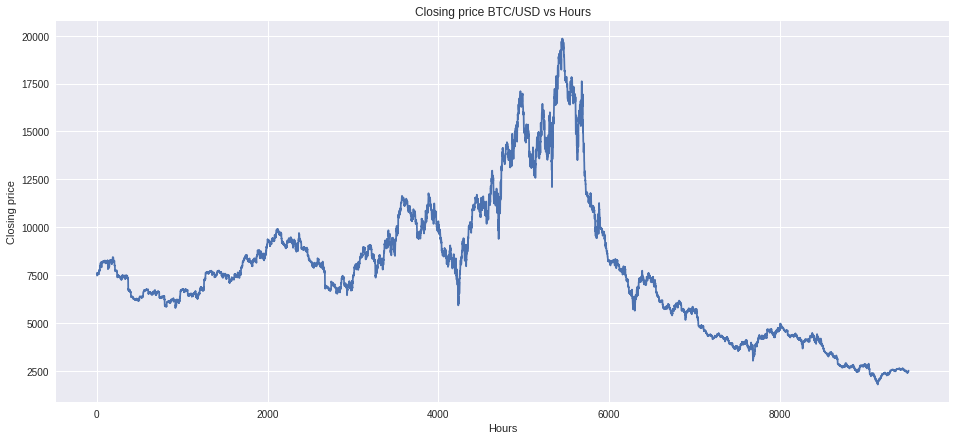

In [22]:
fig, axes = plt.subplots(figsize=(16,7))
axes.plot(prices)
axes.set(xlabel='Hours',ylabel='Closing price',title='Closing price BTC/USD vs Hours')

## Analysis
We would place short term trades on a day to day scale, so lets look at a 5 days

[Text(0,0.5,'Closing price'), Text(0.5,0,'Hours'), Text(0.5,1,'5 Days')]

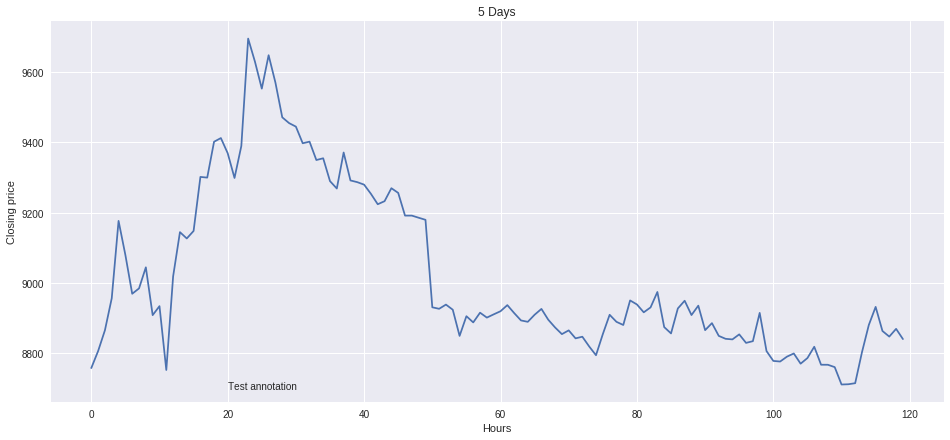

In [23]:
interval = 24 * 5
start = 2345

interval_prices = prices[start:start+interval]

fig, axes = plt.subplots(figsize=(16,7))
axes.plot(interval_prices)
annot = axes.annotate('Test annotation', [20, 8700])
axes.set(xlabel='Hours', ylabel='Closing price', title='5 Days')

The longer the time period we try to predict the less confident we will be in that prediction. So lets say the maximum lookout is 2 days. We could do

# Trading algorithm 
The algorithm that will produce true labels for trades in a given window

In [125]:
# Useful constants and definitions
operations = {
    'NOOP': 0,
    'SELL': 1,
    'BUY': 2, 
}
itoop = {v:k for k,v in operations.items()}

END_TOKEN = (-1, -1)
PROFIT_THRESHOLD = 0.02
OP_WINDOW_LEN = 2*24
ANALYSIS_WINDOW_LEN = 2*24
FRAME_LEN = OP_WINDOW_LEN + ANALYSIS_WINDOW_LEN

In [126]:
# for visualizing the trades our algorithm decided to make
def plot_trades(prices, buy_dist, sell_dist):
    xvalues = [i for i in range(len(prices))]
    
    plt.figure(num=1,figsize=(17, 17))
    
    ax1 = plt.subplot(311)
    ax1.plot(xvalues, prices)
    ax1.set(ylabel='Price in USD', title='Price')

    ax2 = plt.subplot(312)
    ax2.plot(xvalues, buy_dist)
    ax2.set(ylabel='Cumulitative Probability', title='Buy Distribution')
    
    ax3 = plt.subplot(313)
    ax3.plot(xvalues, sell_dist)
    ax3.set(ylabel='Cumulitative Probability', title='Sell Distribution')

    
    plt.show()


### Multi-Trade Algorithm 
can support multiple trades at any one time

In [127]:
def multi_trade(prices):
    """
    frame is divided into two windows:
        one from which our predictions are made
        other in which we place our operations
    knowing lookout distance we can divide into frames after
    """
    operations_window = enumerate(prices)
    operations_window = sorted(operations_window, key=lambda x: x[1])
    window_trades = []
    for i in range(len(operations_window) // 2):
        early, late = find_anchor(operations_window, i) # find which one happened earlier so we can calculate pchange
        pchange = (operations_window[early][1] - operations_window[late][1]) / operations_window[early][1]
        if -pchange >= PROFIT_THRESHOLD:
            start_offset = operations_window[early][0]
            end_offset = operations_window[late][0]
            
            window_trades.append((start_offset / OP_WINDOW_LEN, end_offset / OP_WINDOW_LEN))
            
    window_trades.append(END_TOKEN)
    return window_trades
    
def find_anchor(sarray, idx): # sarray = sorted array
    contra= -(idx+1) # if 0 then -1
    if sarray[idx][0] > sarray[contra][0]:
        return contra , idx
    else:
        return idx, contra

In [128]:
prices = frame['Close'].values
multi_trades = []

def make_trades(prices, results):
    for idx in range(ANALYSIS_WINDOW_LEN, len(prices)):
        operations_window = prices[idx:idx+OP_WINDOW_LEN].copy()
        window_trades = multi_trade(operations_window)
        results.append(window_trades)
        #if idx % 1000 == 0: print(f"idx: [{idx}]")

In [129]:
%time make_trades(prices, multi_trades)

CPU times: user 386 ms, sys: 133 µs, total: 386 ms
Wall time: 381 ms


In [130]:
from collections import Counter
lens = [len(multi_trades[i]) for i in range(len(multi_trades))]
c = Counter(lens)
c.most_common(3)

[(1, 3007), (2, 618), (3, 483)]

### Visualization of the Multi-Trade algorithm 

In [131]:
def compute_distribution(dists, n=OP_WINDOW_LEN):
    """
    dsits List[(pbuy,psell)]
    """
    num_trades = len(dists)
    buy_dist = np.zeros((num_trades, n))
    sell_dist = np.zeros((num_trades, n))
    for i in range(num_trades):
        for k in range(n):
            buy_dist[i, k] = binom.pmf(k, n, dists[i][0])
            sell_dist[i, k] = binom.pmf(k,n, dists[i][1])
    return np.sum(buy_dist,axis=0), np.sum(sell_dist,axis=0)

number of frames available: [9464]
frame number: [5326]


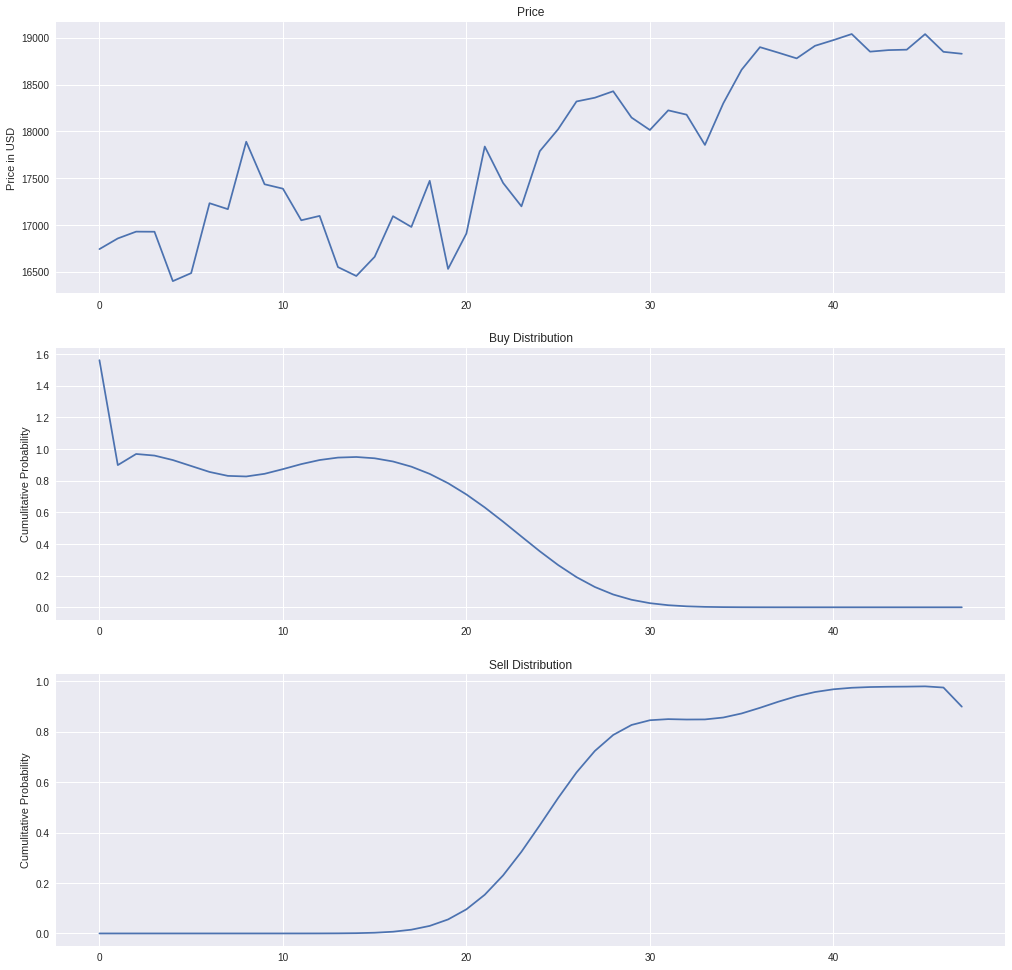

In [132]:
colors = {
    'SELL': 'yellow',
    'SHORT': 'green',
    'BUY': 'cyan', 
}

nframes = len(multi_trades)
print(f"number of frames available: [{nframes}]")

chosen_frame = np.random.randint(0, nframes)
print(f"frame number: [{chosen_frame}]")
start = chosen_frame + ANALYSIS_WINDOW_LEN
interval_prices = prices[start:start+OP_WINDOW_LEN]
buy_dist, sell_dist = compute_distribution(multi_trades[chosen_frame][:-1])


plot_trades(interval_prices, buy_dist, sell_dist)

## Systematic approach for other currencies

In [133]:
import pickle
for path in DATA.iterdir():
    if '.csv' in str(path):
        df = pd.read_csv(path)
        prices = df['Close'].values[1:] # to match dimensions of stationary series
        multi_trades = []
        make_trades(prices, multi_trades)
        file_name = path.name.split('_')[-2] + '_binom_prob_profit0.02_v4.npy'
        print(f"saving: [{file_name}] with shape: {len(multi_trades)}")
        with (DATA/file_name).open('wb') as f: pickle.dump(multi_trades, f)

saving: [ETHUSD_binom_prob_profit0.02_v4.npy] with shape: 9463
saving: [BTCUSD_binom_prob_profit0.02_v4.npy] with shape: 9463
saving: [LTCUSD_binom_prob_profit0.02_v4.npy] with shape: 9463
